In [13]:
# Core imports
import requests
import os
from dotenv import load_dotenv
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Visualization imports
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import numpy as np
from collections import Counter

# Configure matplotlib
%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')

# Load API key
load_dotenv()
finnhub_key = os.getenv("FINNHUB_API_KEY")
if not finnhub_key:
    raise ValueError("⚠️ Please add your FINNHUB_API_KEY to .env file")

print("✅ All libraries loaded and API key ready")

✅ All libraries loaded and API key ready


In [14]:
# Function to clean headlines
def clean_text(text):
    if not text:
        return ""
    text = text.strip()
    text = re.sub(r"[^\w\s.,?!]", "", text)
    text = re.sub(r"\s+", " ", text)
    return text

# Initialize VADER
analyzer = SentimentIntensityAnalyzer()

# Function to classify sentiment
def get_sentiment_vader(text):
    scores = analyzer.polarity_scores(text)
    compound = scores['compound']
    if compound >= 0.05:
        return "Bullish"
    elif compound <= -0.05:
        return "Bearish"
    else:
        return "Neutral"

In [15]:
def extract_keywords(news_list):
    """Extract top 10 keywords from headlines"""
    stop_words = {'the', 'a', 'an', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for',
                  'of', 'with', 'is', 'are', 'was', 'were', 'be', 'been', 'has', 'have'}
    
    all_words = []
    for item in news_list:
        words = re.findall(r'\b[a-z]{4,}\b', item['title'].lower())
        all_words.extend([w for w in words if w not in stop_words])
    
    return Counter(all_words).most_common(10)

In [16]:
def fetch_news(ticker, from_date="2026-01-10", to_date="2026-01-14"):
    url = f"https://finnhub.io/api/v1/company-news?symbol={ticker}&from={from_date}&to={to_date}&token={finnhub_key}"
    
    try:
        data = requests.get(url).json()
    except Exception as e:
        print("Error fetching news:", e)
        return []
    
    headlines = []
    for item in data[:5]:
        title = clean_text(item.get("headline", ""))
        link = item.get("url", "")
        headlines.append({"title": title, "link": link})
    
    if not headlines:
        print("⚠️ No headlines found. Check ticker or date range!")
    
    return headlines

In [17]:
ticker = "AAPL"
news = fetch_news(ticker)

for i, item in enumerate(news, 1):
    title = item['title']
    sentiment = get_sentiment_vader(title)
    print(f"{i}. {title}")
    print(f"   Link: {item['link']}")
    print(f"   Sentiment: {sentiment}\n")

print(f"✅ Collected {len(news)} headlines for visualization")

1. Stock market today Nasdaq futures lead Dow, SP 500 higher as TSMCs strong outlook buoys AI hopes
   Link: https://finnhub.io/api/news?id=d9a58e608e6a909dbd4f7ba690aa965fae1a8016771855b22fd33e360784a600
   Sentiment: Bullish

2. Stock market today Dow, SP 500, Nasdaq futures rise as chipmaker TSMCs strong outlook buoys optimism for AI
   Link: https://finnhub.io/api/news?id=b93efeafbf92a3339feeceec557c69f110c6f96edc5a58c325396ab5e2f57d42
   Sentiment: Bullish

3. TSMC likely to post fourthquarter profit leap driven by AI boom
   Link: https://finnhub.io/api/news?id=b9fa2f285e852b27a13beb4b549ac91f9914943d44cbcf4239bae46908db7300
   Sentiment: Bullish

4. TSMC smashes forecasts with record profit, flags more US factories
   Link: https://finnhub.io/api/news?id=3041524a382cad365ef579ed84feb318dfe05b8e166092127c60e3542652e7e2
   Sentiment: Bullish

5. Is Apples AI partnership with Google a major loss for OpenAI?
   Link: https://finnhub.io/api/news?id=9645477a144fc94aca9c12c5b46b4c190f8

📊 Saved: AAPL_sentiment_pie.png


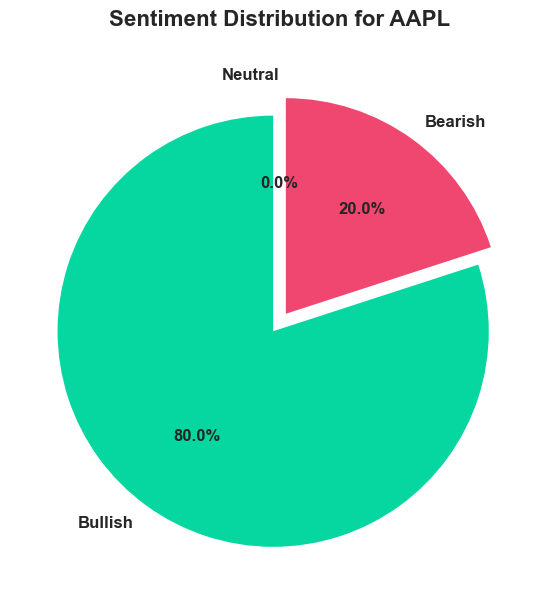

In [18]:
if news:
    sentiments = [get_sentiment_vader(item['title']) for item in news]
    sentiment_counts = {
        'Bullish': sentiments.count('Bullish'),
        'Bearish': sentiments.count('Bearish'),
        'Neutral': sentiments.count('Neutral')
    }
    
    plt.figure(figsize=(10, 7))
    colors = ['#06D6A0', '#EF476F', '#FFD166']
    explode = (0.05, 0.05, 0.05)
    
    plt.pie(
        sentiment_counts.values(),
        labels=sentiment_counts.keys(),
        autopct='%1.1f%%',
        colors=colors,
        explode=explode,
        startangle=90,
        textprops={'fontsize': 12, 'fontweight': 'bold'}
    )
    plt.title(f'Sentiment Distribution for {ticker}', fontsize=16, fontweight='bold', pad=20)
    
    filename = f"{ticker}_sentiment_pie.png"
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    print(f"📊 Saved: {filename}")
    plt.show()
else:
    print("❌ No data to visualize")

In [19]:
if news:
    sentiments = [get_sentiment_vader(item['title']) for item in news]
    bullish = sentiments.count('Bullish')
    bearish = sentiments.count('Bearish')
    neutral = sentiments.count('Neutral')
    total = len(news)
    
    print("\n" + "="*70)
    print(f"📊 SENTIMENT SUMMARY FOR {ticker}")
    print("="*70)
    print(f"\nTotal Headlines Analyzed: {total}")
    print(f"\n{'Bullish:':<10} {bullish:>2d} ({bullish/total*100:>5.1f}%) {'█' * int(bullish/total*30)}")
    print(f"{'Bearish:':<10} {bearish:>2d} ({bearish/total*100:>5.1f}%) {'█' * int(bearish/total*30)}")
    print(f"{'Neutral:':<10} {neutral:>2d} ({neutral/total*100:>5.1f}%) {'█' * int(neutral/total*30)}")
    print("\n" + "="*70)
    
    if bullish > bearish:
        print(f"📈 Overall Sentiment: BULLISH")
    elif bearish > bullish:
        print(f"📉 Overall Sentiment: BEARISH")
    else:
        print(f"➡️  Overall Sentiment: NEUTRAL")
    print("="*70)


📊 SENTIMENT SUMMARY FOR AAPL

Total Headlines Analyzed: 5

Bullish:    4 ( 80.0%) ████████████████████████
Bearish:    1 ( 20.0%) ██████
Neutral:    0 (  0.0%) 

📈 Overall Sentiment: BULLISH
